## Analyzing m5C patterns in Human oocyte and embryonic stem cells (CPU-based)

---

Author: Jianheng Liu @ Rui Zhang's Lab, SYSU, China

Email: jhfoxliu@gmail.com

Date: Jan, 2022

## Packages

- Python==3.7.8
- numpy==1.20.0
- scipy==1.5.1
- umap-learn==0.5.2
- sklearn==0.23.1
- matplotlib==3.2.2
- seaborn==0.10.1
- hdbscan==0.8.27

## 0. Configure environment

In [1]:
import time
import sys, os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import scipy.stats
import tracemalloc
import umap
import hdbscan

# for Linux only, load font file
mpl.font_manager.fontManager.addfont("./arial.ttf")

# configure matplotlib
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

tracemalloc.start()


This is a helper function useful for export fasta and motifs.

In [2]:
def extract_fasta_and_draw_motifs(prefix, df, cluster_col="Cluster", filter=None, motif_column=("INFO", "motif_F10"), draw_logos=True):
    print("===============  {} ===============".format(prefix))
    if os.path.isdir("{}".format(prefix)) == False:
        os.mkdir("./{}".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    else:
        os.system("rm -r ./{}/*".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    if filter is not None:
        df = df[df[filter] == True].copy()
    clusters = set(df[cluster_col].tolist())
    for g in clusters:
        subdf = df[df[cluster_col] == g]
        with open("./{}/fasta/cluster_{}.fa".format(prefix, g), "w") as output:
            N = 0
            for idx, row in subdf.iterrows():
                output.write(">{}\n{}\n".format(idx, row[motif_column].replace("T", "U")))  # to RNA bases
                N += 1
            print("Cluster #{}: {}".format(g, N))
    if draw_logos == True:
        for g in clusters:
            os.system("weblogo -A rna -D fasta -F pdf --resolution 1000 --color-scheme classic --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A rna -D fasta -F png --resolution 1000 --color-scheme classic --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_png/cluster_{g}.png".format(prefix=prefix, g=g))

            os.system("weblogo -A rna -D fasta -F pdf -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A rna -D fasta -F png -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq_png/cluster_{g}.png".format(prefix=prefix, g=g)) 
            
            os.system("weblogo -A rna -D fasta -X no -Y no -P \"\" -F pdf --resolution 1000 --color-scheme classic --composition none -i -10 -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_no_axis/cluster_{g}.pdf".format(prefix=prefix, g=g))

In [3]:
def show_logos(prefix, names=None):
    for img in os.listdir(prefix):
        if img.endswith(".png") == False:
            continue
        if names is not None and fn not in names:
            continue
        plt.figure()
        image = plt.imread(prefix+"/"+img)
        plt.imshow(image)
        plt.axis("off")

In [5]:
def show_logos_cols(prefix, names=None, cols=2, figsize=(8,8), auto_size=True):
    file_list = []
    for img in os.listdir(prefix):
        if img.endswith(".png") == False:
            continue
        if names is not None and fn not in names:
            continue
        file_list.append(img)
    
    file_list_format = []
    for i in file_list:
        id = int(i.replace("cluster_", "").replace(".png", ""))
        file_list_format.append((i, id))
    file_list_format = sorted(file_list_format, key=lambda x:x[1]) 
    
    if len(file_list_format) % cols == 0:
        rows = len(file_list_format) // cols
    else:
        rows = len(file_list_format) // cols + 1
    if auto_size == False:
        figsize = figsize
    else:
        width = 4 * cols
        height = 1.5 * rows
        figsize = (width, height)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for ax, image in zip(*[axes.reshape(-1), file_list_format]):
        fn, id = image
        img = plt.imread(prefix+"/"+fn)
        _ = ax.imshow(img)
        ax.set_title("cluster_{}".format(id))
    for ax in axes.reshape(-1):
        ax.axis("off")
    plt.tight_layout()

This is a helper function useful for MEME analysis.

In [4]:
def run_meme(prefix, fasta_prefix, fn, mode=["streme", "meme", "ce", "cd"], nmotifs=5):
    if os.path.isdir("./{}/meme".format(prefix)) == False:
        os.mkdir("./{}/meme".format(prefix))
    else:
        os.system("rm -r ./{}/meme/*".format(prefix))
    for m in mode:
        if m == "meme":
            # Normal mode
            print("Runing MEME...")
            os.system("meme -rna -nmotifs {nmotifs} -minw 5 -maxw 10 -oc ./{prefix}/meme/{out}_meme ./{fasta_prefix}/{fn}".format(fn=fn, prefix=prefix, nmotifs=nmotifs, fasta_prefix=fasta_prefix, out=fn.strip(".fa")))
        elif m == "ce":
            # CE mode
            print("Runing MEME in CE mode...")
            os.system("meme -rna -objfun ce -cefrac 0.1 -nmotifs {nmotifs} -minw 5 -maxw 10 -oc ./{prefix}/meme/{out}_meme_ce ./{fasta_prefix}/{fn}".format(fn=fn, prefix=prefix, nmotifs=nmotifs, fasta_prefix=fasta_prefix, out=fn.strip(".fa")))
        elif m == "cd":
            # CE mode
            print("Runing MEME in CD mode...")
            os.system("meme -rna -objfun cd -cefrac 0.1 -nmotifs {nmotifs} -minw 5 -maxw 10 -oc ./{prefix}/meme/{out}_meme_cd ./{fasta_prefix}/{fn}".format(fn=fn, prefix=prefix, nmotifs=nmotifs, fasta_prefix=fasta_prefix, out=fn.strip(".fa")))
        elif m == "streme":
            print("Runing STREME")
            os.system("streme --rna --pvt 0.05 -nmotifs {nmotifs} --minw 5 --maxw 10 --objfun cd --oc ./{prefix}/meme/{out}_streme --p ./{fasta_prefix}/{fn}".format(fn=fn, prefix=prefix, fasta_prefix=fasta_prefix, nmotifs=nmotifs, out=fn.strip(".fa")))

## 1. Load data and Hot-hot encoded

In pratices, 'ATCG' and 'ATCGN' do not have huge difference. We can also mask 'N' into [0,0,0,0] rather than consider is a kind of base.

Notably, the discard of 'N' saves up to 20% of memory usage!

In [6]:
df = pd.read_csv("./Human_dev.motif.F10.csv", index_col=[0,1,2], header=[0,1])

enc = OneHotEncoder(dtype=np.int8)
enc.fit([[i] for i in "ATCGN"])

def onehot_enc(row):
    seq = [[i] for i in row[("INFO", "motif_F10")].upper()]
    return enc.transform(seq).toarray().reshape(-1)

onehot_input = []
for idx, row in df.iterrows():
    onehot_input.append(onehot_enc(row))
onehot_input = np.array(onehot_input)

## 2. Dimensional reduction wit UMAP

In UMAP, we can adjust `min_dist`, `n_neighbors`, and `densmap` for different strength of decomposition. Lower (close to zero) `min_dist` is recommended for motif analysis. Higher `n_neighbors` can result in much condensed clusters, however, this will consume more time and memory, and its effect diminishes marginally. `densmap=True` can result in much condensed clusters, and of course, 2x computation time. With `densmap=True` you might ignore some patterns different but similar (e.g. motifs of NSUN2 and Nop2), hence it is not recommanded.

It is known that duplication of input might reduce the efficiency of UMAP. You can use `unique=True` in UMAP and use `_unique_inverse_` to get back the data. You can also pre-process the data you use and then recover it before HDBSCAN (density is matter, we don't only care about the k-mers feature). [Ignore it if duplication rate is not high.]



In [7]:
def UMAP(onehot_input, df):
    df = df.copy()
    # this should takes ~20 sec   
    print("UMAP")
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = umap.UMAP(init="random", random_state=42, n_components=2, min_dist=0.01, n_neighbors=20, verbose=True, densmap=False)
    umap_output = model.fit_transform(onehot_input)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    
    print("UMAP time: {} sec".format(time1))
    print("UMAP RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = umap_output[:, 0]
    df["Y"] = umap_output[:, 1]
    
    del model
    return time1, mem, df

_, _, df_UMAP = UMAP(onehot_input, df)

UMAP
UMAP(init='random', min_dist=0.01, n_neighbors=20, random_state=42, verbose=True)
Wed Jan 19 01:43:35 2022 Construct fuzzy simplicial set
Wed Jan 19 01:43:35 2022 Finding Nearest Neighbors
Wed Jan 19 01:43:35 2022 Building RP forest with 15 trees
Wed Jan 19 01:43:37 2022 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
	 7  /  15
	Stopping threshold met -- exiting after 7 iterations
Wed Jan 19 01:46:57 2022 Finished Nearest Neighbor Search
Wed Jan 19 01:47:01 2022 Construct embedding



Wed Jan 19 01:47:51 2022 Finished embedding
UMAP time: 256.9546401500702 sec
UMAP RAM: 249.2234649658203 MB



## 3. Cluster sites with HDBSCAN

In HDBSCAN, we can adjust `min_cluster_size`, `min_samples`, `cluster_selection_epsilon` and `cluster_selection_method` to adjust the strength of clustering. Check https://hdbscan.readthedocs.io/en/latest/index.html for more information.


In [8]:
def cluster_HDBSCAN_softclustering(df):
    # use multi-code here
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=1, cluster_selection_method='eom', core_dist_n_jobs=4, prediction_data=True)
    yhat = model.fit(X)
    
    soft_clusters = hdbscan.all_points_membership_vectors(yhat)
    labels = [np.argmax(x) for x in soft_clusters] 
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    df["Cluster"] = [i+1 if i > -1 else -1 for i in labels ]  # re-number lables to make it human-readable
    
    print("HDBSCAN soft clustering time: {} sec".format(time1))
    print("HDBSCAN soft clustering RAM: {} Mb".format(mem))
    print("HDBSCAN cluster number: {}".format(df["Cluster"].max()))
    print("==================================================")
    # check cluster number
    print(df.groupby("Cluster")["Cluster"].count())
    return time1, mem, df, model

_, _, df_HDBSCAN, HDBSCAN_model = cluster_HDBSCAN_softclustering(df_UMAP)



HDBSCAN soft clustering time: 8.029974699020386 sec
HDBSCAN soft clustering RAM: 195.8099136352539 Mb
HDBSCAN cluster number: 3
Cluster
1    10595
2      722
3    30414
Name: Cluster, dtype: int64


In [9]:
tracemalloc.stop()

## 3.1 Draw single_linkage_tree of HDBSCAN (optional, slow)

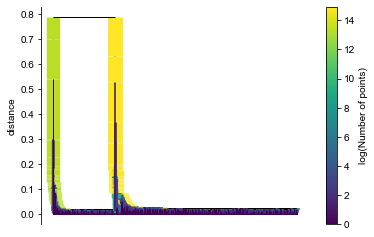

In [10]:
fig, ax = plt.subplots()
HDBSCAN_model.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
plt.savefig("HDBSCAN_single_linkage_tree.pdf")
plt.show()

## 3.2 Draw condensed_tree of HDBSCAN (optional, suggested)

Condensed tree is something benefits us in understanding how well HDBSCAN works. In this tree, we can clear find that HDBSCAN split the dataset into three major leaf/groups (blue, orange, and green). We can also notice that, the blue leaf and green leaf are much condensed, which means that the sequences in these two leafs are more similar to each other intergroup. In contrast, the green one has a more degenerated pattern.

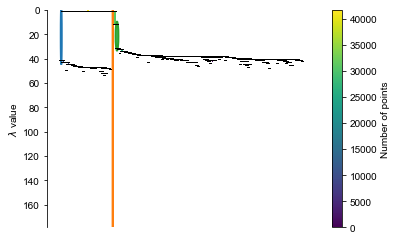

In [11]:
fig, ax = plt.subplots()
HDBSCAN_model.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.savefig("HDBSCAN_condensed_tree.pdf")
plt.show()

## 4 Draw figure

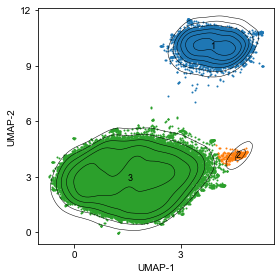

In [12]:
fig, ax = plt.subplots(1, figsize=(4,4))

def draw_clusters(ax, df, fn):
    clusters = set(df["Cluster"].tolist())

    for i in clusters:
        subdf = df[df["Cluster"]==i]
        if i == -1:
            ax.scatter(subdf["X"], subdf["Y"], s=1, c="lightgray", lw=None, label=i)
        else:
            ax.scatter(subdf["X"], subdf["Y"], s=1, alpha=1, lw=None, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            ax.annotate("{}".format(i), xy=(c_X, c_Y), color="k", ha="center", va="center", size=9) # , size=13

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # draw density
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")

    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
    
    df.to_csv("{}".format(fn))
    
draw_clusters(ax, df_HDBSCAN, "Human_dev.motif.F10.clustered.csv")

plt.tight_layout()

plt.savefig("Human_dev.pdf")
plt.show()

## 5.1 Extract fasta and draw motif (require MEME)

Here we use a automatic function to finish fasta extraction and motif drawing.

Our strategy is very fast. With clustering, we can focus on much clear targets in configuration of a run of MEME. We can learn the window range, the position, and other important information about the motif candidates.

In [13]:
extract_fasta_and_draw_motifs("Human_dev", df_HDBSCAN, motif_column=("INFO", "motif_F10"))

===============  Human_dev ===============
Cluster #1: 10595
Cluster #2: 722
Cluster #3: 30414


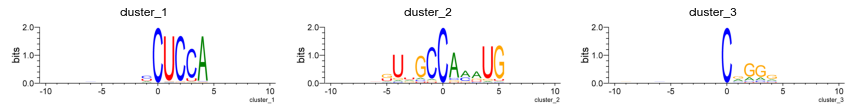

In [14]:
show_logos_cols("./Human_dev/logos_bits_png/", cols=3)

## 5.2 Motif discovery with MEME (require MEME)

Of course, no method is 100% perfect. With MEME, we can check if we missed something in our clusters. We can also compare the results from MEME **before** and **after** clustering. Without the aid of clustering, MEME works hard in comprehensively uncover all of the motifs. 

In [15]:
# run meme with all fasta output
# skipped

#for fn in os.listdir("./Human_dev/fasta/"):
    #run_meme("Human_dev", "./Human_dev/fasta/", fn, mode=["streme", "meme", "ce", "cd"], nmotifs=2)

In [16]:
# check all sequences
# skipped

#os.system("cat ./Human_dev/fasta/*fa > ./Human_dev/meme/merged.fa")

# STREME
#!streme --rna --pvt 0.05 -nmotifs 10 --minw 5 --maxw 10 --objfun cd --oc ./Human_dev/meme/merged_streme -p ./Human_dev/meme/merged.fa
# Normal mode
#!meme -rna -nmotifs 8 -minw 5 -maxw 10 -oc ./Human_dev/meme/merged_meme ./Human_dev/meme/merged.fa
# CE mode
#!meme -rna -objfun ce -nmotifs 8 -cefrac 0.1 -minw 5 -maxw 10 -oc ./Human_dev/meme/merged_meme_ce ./Human_dev/meme/merged.fa
# CD mode
#!meme -rna -objfun cd -nmotifs 8 -minw 5 -maxw 10 -oc ./Human_dev/meme/merged_meme_cd ./Human_dev/meme/merged.fa